In [1]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt

from election import DHondt
from voters import Saint, Spineless, Follower, Opportunist, NonConformist, Strategist
from parties import Party
from sampling import sample_parties, sample_voters
from plotting import plot_spectrum, plot_seats_multiple_runs, plot_flow_graph

In [2]:

#MODEL HYPERPARAMETERS
DEMOGRAPHIC = {Saint:[[] for i in range(1000)], 
               Spineless:[[]for i in range(10)],
               Follower:[[2] for i in range(100)] + [[3] for i in range(1000)] + [[4] for i in range(1000)],
               Opportunist:[[2] for i in range(1000)] + [[3] for i in range(100)] +[[4] for i in range(100)],
               NonConformist:[[3] for i in range(1000)],
               Strategist:[[3,2] for i in range(1000)] + [[2,1] for i in range(1000)]
               }
NUM_ELECTIONS = 100
NUM_CLUSTERS = 8
NUM_PARTIES = 10
NUM_SEATS = 150
NUM_POLLS = 10
DIM = 2
RANGE_MEANS = [-1, 1]
RANGE_V_STD = [0.1, 0.3]
RANGE_P_STD = [0.1, 0.3]

SEEDS = range(NUM_ELECTIONS)
#SAMPLING
np.random.seed(SEEDS[0])

#pmeans = list(np.random.uniform(RANGE_MEANS[0], RANGE_MEANS[1], (NUM_CLUSTERS, DIM))) 
#vmeans = list(np.random.uniform(RANGE_MEANS[0], RANGE_MEANS[1], (NUM_CLUSTERS, DIM)))
pmeans = [[-0.8,0.8],[-0.3, 0.3],[0,0],[0.3,-0.3],[0.8,-0.8]] + list(np.random.uniform(RANGE_MEANS[0], RANGE_MEANS[1], (NUM_CLUSTERS-5, DIM))) 
vmeans = pmeans
#pstds = np.random.uniform(RANGE_P_STD[0], RANGE_P_STD[1], NUM_CLUSTERS)
pstds = [0.1,0.2,0.5,0.2, 0.1] + list(np.random.uniform(RANGE_P_STD[0], RANGE_P_STD[1], NUM_CLUSTERS-5))
#vstds = np.random.uniform(RANGE_V_STD[0], RANGE_V_STD[1], NUM_CLUSTERS)
vstds=pstds
#vstds = [0.1, 0.2, 0.5, 0.2, 0.1]
weights = np.random.uniform(0.3, 1, NUM_CLUSTERS)
#weights = np.array([0.35, 0.1, 0.2, 0.1, 0.35])
weights /= sum(weights)

party_modes = {'modes':[{'mean': pmeans[i], 'std':pstds[i], 'weight':weights[i]} for i in range(NUM_CLUSTERS)]}
voter_modes = {'modes':[{'mean': vmeans[i], 'std':vstds[i], 'weight':weights[i]} for i in range(NUM_CLUSTERS)]}

In [3]:
#RUN ELECTION
outcomes = []
switch_matrix = np.zeros((NUM_PARTIES, NUM_PARTIES))

colormap = {Saint:'red', Spineless:'blue', Follower:'green', Opportunist:'yellow', NonConformist:'magenta', Strategist:'cyan'}

parties = sample_parties(NUM_PARTIES, distribution='multimodal', dim=2, params=party_modes, representation=True)
for election in range(NUM_ELECTIONS):
    #np.random.seed(SEEDS[election])
    voters = sample_voters(DEMOGRAPHIC, parties, distribution='multimodal', dim=2, params=voter_modes, shuffle=False)
    colors = [colormap[type(voter)] for voter in voters]
    ExElection = DHondt(voters, parties, num_seats=NUM_SEATS, num_polls=NUM_POLLS)
    [party.compute_poldeg(ExElection.voters) for party in ExElection.parties]
    outcome = ExElection.run()
    outcomes.append(outcome)
    for voter in ExElection.voters:
        switch_matrix[voter.preference[0].idx, voter.ballot[0].idx] += 1

outcome

[Counter({Party(f, 0.0): 35,
          Party(h, 0.46): 35,
          Party(a, 0.25): 19,
          Party(g, 0.0): 19,
          Party(e, 0.0): 16,
          Party(c, 0.0): 11,
          Party(b, 0.0): 9,
          Party(d, 0.0): 6}),
 Counter({Party(f, 0.0): 47,
          Party(h, 0.46): 24,
          Party(a, 0.25): 20,
          Party(e, 0.0): 18,
          Party(g, 0.0): 17,
          Party(d, 0.0): 10,
          Party(c, 0.0): 9,
          Party(b, 0.0): 5}),
 Counter({Party(f, 0.0): 46,
          Party(e, 0.0): 26,
          Party(h, 0.46): 24,
          Party(a, 0.25): 20,
          Party(g, 0.0): 11,
          Party(c, 0.0): 9,
          Party(d, 0.0): 8,
          Party(b, 0.0): 6}),
 Counter({Party(f, 0.0): 39,
          Party(e, 0.0): 31,
          Party(h, 0.46): 30,
          Party(a, 0.25): 15,
          Party(g, 0.0): 12,
          Party(c, 0.0): 9,
          Party(d, 0.0): 8,
          Party(b, 0.0): 6}),
 Counter({Party(f, 0.0): 39,
          Party(e, 0.0): 31,
        

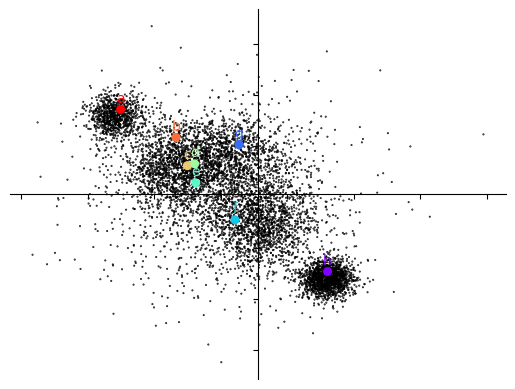

In [4]:
#PLOTS
#Plotting political spectrum
cmap = plt.get_cmap('rainbow_r')
norm = plt.Normalize(0, NUM_PARTIES - 1)
colors = cmap(norm(np.arange(NUM_PARTIES)))

pcmap = {party.name: colors[i] for i, party in enumerate(parties)}
plot_spectrum(voters, parties, pcmap=None)

[0.         0.17333333 0.32       0.26666667 0.32       0.28
 0.26666667 0.32       0.28       0.26666667]


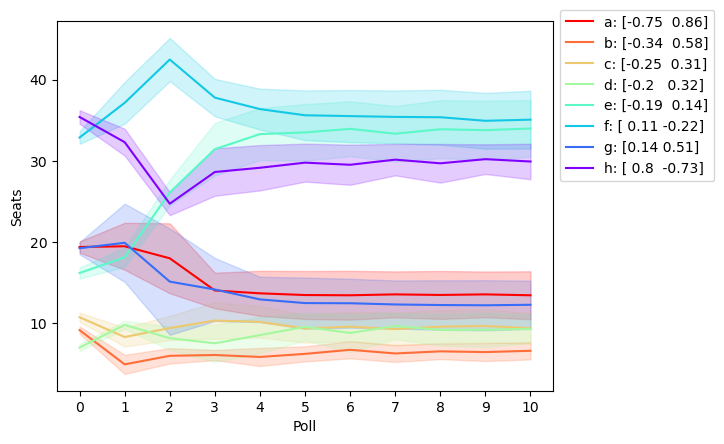

[Party(a, 0.25), Party(b, 0.0), Party(c, 0.0), Party(d, 0.0), Party(e, 0.0), Party(f, 0.0), Party(g, 0.0), Party(h, 0.46)]


In [5]:
untruthfullness = np.array([np.sum(np.abs(np.array(list(outcomes[0][p].values()))-np.array(list(outcomes[0][0].values())))) for p in range(NUM_POLLS)])/NUM_SEATS
print(untruthfullness)
plot_seats_multiple_runs(outcomes)
print(parties)

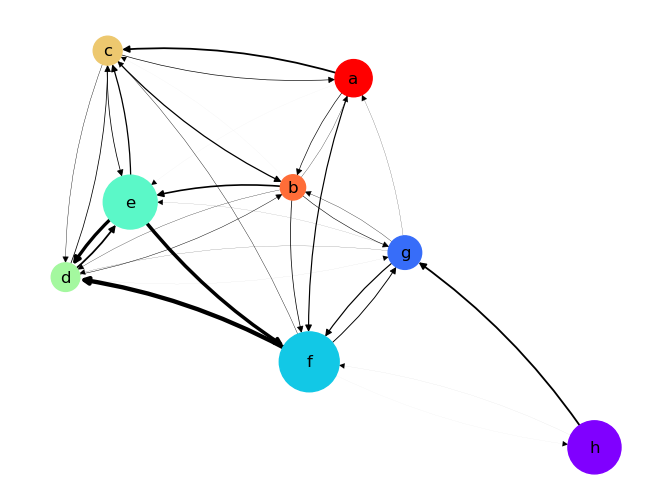

[Party(a, 0.25), Party(b, 0.0), Party(c, 0.0), Party(d, 0.0), Party(e, 0.0), Party(f, 0.0), Party(g, 0.0), Party(h, 0.46)]


In [6]:
plot_flow_graph(ExElection)
print(parties)